 # Radiomics model building using Auto ML
 Wookjin Choi <wookjin.choi@jefferson.edu>

 ## Import modules

In [1]:
import autosklearn
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn import datasets, cluster
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np


 ## 1. Data loading

In [2]:
clinical_lidc72 = pd.read_csv("metadata/LIDC_72.csv")
clinical_lidc = pd.read_csv("metadata/LIDC.csv")
clinical_lungx = pd.read_csv("metadata/LUNGx.csv")

#features_lidc = pd.read_csv("output/feature-list_nodule-lidc_pylidc.csv")
features_lidc = pd.read_csv("output/feature-list_nodule-lidc.csv")
features_lungx = pd.read_csv("output/feature-list_nodule-lungx.csv")

lidc_tags = features_lidc.Tags.str.split("-").apply(pd.Series)
features_lidc['nid'] = lidc_tags[0]
features_lidc['Tags'] = lidc_tags[1]

lungx_tags = features_lungx.Tags.str.split("-").apply(pd.Series)
lungx_tags.iloc[lungx_tags[2].isna(), 1] = "gc"
#lungx_tags.iloc[lungx_tags[2].isna(), 2] = "1mm"

features_lungx['nid'] = lungx_tags[0]
features_lungx['Tags'] = lungx_tags[1]

features_lidc = features_lidc.loc[(features_lidc.Tags=='seg') & (features_lidc.nid=='1')]
features_lungx = features_lungx.loc[(features_lungx.Tags=='seg')]

#features_lidc = features_lidc.drop(columns=["WeightedElongation","WeightedFlatness","2DWeightedElongation","2DWeightedFlatness"])
#features_lungx = features_lungx.drop(columns=["WeightedElongation","WeightedFlatness","2DWeightedElongation","2DWeightedFlatness"])
features_lidc72 = features_lidc.loc[features_lidc.PID.isin(clinical_lidc72.PID)]
features_lidc_train = features_lidc.loc[~features_lidc.PID.isin(clinical_lidc72.PID)]
clinical_lidc_train = clinical_lidc.loc[~clinical_lidc.PID.isin(clinical_lidc72.PID)]

 ### 1.1 Data preprocessing

In [3]:
X = features_lidc_train.iloc[:, 4:-1]
X = X.loc[:,X.isna().sum(axis=0)==0]
y = clinical_lidc_train.Malignancy > 3

X_72 = features_lidc72.iloc[:, 4:-1]
X_72 = X_72.loc[:, X.columns]
y_72 = clinical_lidc72.PMalignancy == 2

X_lungx = features_lungx.iloc[:, 4:-1]
X_lungx = X_lungx.loc[:, X.columns]
y_lungx = clinical_lungx.malignancy > 0


X_lungx_cal = X_lungx.iloc[0:10]
y_lungx_cal = y_lungx.iloc[0:10]
X_lungx_test = X_lungx.iloc[10:]
y_lungx_test = y_lungx.iloc[10:]



 ### 1.2 Data splitting

In [4]:
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)


 ## 2. Feature Selection

 ### 2.1 Redundant Feature Elimination

In [5]:
agglo = cluster.FeatureAgglomeration(affinity='precomputed', linkage='single', n_clusters=None, distance_threshold=0.4)
agglo.fit(1-abs(X_train.corr()))

feature_groups = [np.array(X_train.columns[agglo.labels_==i]) for i in np.unique(agglo.labels_)]
feature_reps = [f[0] for f in feature_groups]
feature_reps


['Eccentricity',
 '2DPrincipalAxes1',
 'PhysicalSize',
 'WeightedPrincipalAxes9',
 'WeightedPrincipalAxes8',
 'Maximum',
 'MeanOfLongRunLowGreyLevelEmphasis',
 'WeightedPrincipalAxes7',
 'WeightedPrincipalAxes1',
 'WeightedPrincipalAxes3',
 'Orientation',
 '2DWeightedPrincipalMoments1',
 '2DElongation',
 'WeightedPrincipalAxes2',
 'PrincipalAxes5',
 'WeightedPrincipalAxes6',
 'PrincipalAxes2',
 'PrincipalAxes1',
 'PrincipalAxes7',
 'PrincipalAxes6',
 'PrincipalAxes4',
 'PrincipalAxes9',
 'PrincipalAxes8',
 'WeightedPrincipalAxes4',
 'WeightedPrincipalMoments1',
 'WeightedPrincipalAxes5',
 'StandardDeviationOfShortRunEmphasis',
 'PrincipalAxes3',
 'Flatness']

In [6]:
#X_reduced_tr = pd.DataFrame(agglo.transform(X_train))
#X_reduced_ts = pd.DataFrame(agglo.transform(X_test))
#X_reduced_tr.columns = feature_reps
#X_reduced_ts.columns = feature_reps

X_reduced_tr = X_train[feature_reps]
X_reduced_ts = X_test[feature_reps]

print(X_reduced_tr.shape, X_reduced_ts.shape)
feature_groups[0].shape


(648, 29) (163, 29)


(2,)

In [7]:
X_train = X_reduced_tr
X_test = X_reduced_ts


 ### 2.2 Feature Selection

In [8]:
trans = GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0), mode='percentile', param=50)
X_trans = trans.fit_transform(X_train, y_train)

mutual_information = mutual_info_classif(X_train, y_train) 
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=20)
X_trans = trans.fit_transform(X_train, y_train)
columns_retained_Select = X_train.columns[trans.get_support()].values
columns_retained_Select


array(['2DPrincipalAxes1', 'PhysicalSize', 'WeightedPrincipalAxes9',
       'Maximum', 'MeanOfLongRunLowGreyLevelEmphasis',
       'WeightedPrincipalAxes7', 'WeightedPrincipalAxes1',
       'WeightedPrincipalAxes3', '2DWeightedPrincipalMoments1',
       '2DElongation', 'PrincipalAxes5', 'WeightedPrincipalAxes6',
       'PrincipalAxes7', 'PrincipalAxes8', 'WeightedPrincipalAxes4',
       'WeightedPrincipalMoments1', 'WeightedPrincipalAxes5',
       'StandardDeviationOfShortRunEmphasis', 'PrincipalAxes3',
       'Flatness'], dtype=object)

In [9]:
clf = DecisionTreeClassifier()
clf.fit(X, y)

trans = SelectFromModel(clf, threshold='median', max_features=20)
X_trans = trans.fit_transform(X, y)
columns_retained_FromMode = X.columns[trans.get_support()].values
columns_retained_FromMode


array(['OrientedBoundingBoxSize3', 'PrincipalAxes1', 'PrincipalAxes3',
       'PrincipalAxes7', 'Flatness', 'Orientation',
       'WeightedPrincipalAxes1', 'WeightedPrincipalAxes3',
       'WeightedPrincipalAxes9', 'Variance',
       '2DWeightedPrincipalMoments1', '2DMedian', '2DSkewness',
       'StandardDeviationOfEntropy', 'MeanOfGreyLevelNonuniformity',
       'MeanOfLongRunLowGreyLevelEmphasis',
       'StandardDeviationOfLongRunEmphasis',
       'StandardDeviationOfLowGreyLevelRunEmphasis',
       'StandardDeviationOfShortRunLowGreyLevelEmphasis',
       'StandardDeviationOfLongRunHighGreyLevelEmphasis'], dtype=object)

In [10]:
clf = DecisionTreeClassifier()
trans = RFE(clf, n_features_to_select=20)
X_trans = trans.fit_transform(X_train, y_train)
columns_retained_RFE = X_train.columns[trans.get_support()].values
columns_retained_RFE


array(['Eccentricity', '2DPrincipalAxes1', 'PhysicalSize',
       'WeightedPrincipalAxes9', 'WeightedPrincipalAxes8', 'Maximum',
       'MeanOfLongRunLowGreyLevelEmphasis', 'WeightedPrincipalAxes3',
       'Orientation', '2DWeightedPrincipalMoments1', 'PrincipalAxes5',
       'PrincipalAxes2', 'PrincipalAxes1', 'PrincipalAxes7',
       'PrincipalAxes6', 'PrincipalAxes4', 'WeightedPrincipalAxes4',
       'WeightedPrincipalMoments1', 'PrincipalAxes3', 'Flatness'],
      dtype=object)

In [11]:
clf = DecisionTreeClassifier()
trans = RFECV(clf)
X_trans = trans.fit_transform(X_train, y_train)
columns_retained_RFECV = X_train.columns[trans.get_support()].values
columns_retained_RFECV


array(['Eccentricity', '2DPrincipalAxes1', 'PhysicalSize',
       'WeightedPrincipalAxes9', 'WeightedPrincipalAxes8', 'Maximum',
       'MeanOfLongRunLowGreyLevelEmphasis', 'WeightedPrincipalAxes7',
       'WeightedPrincipalAxes3', 'Orientation',
       '2DWeightedPrincipalMoments1', 'PrincipalAxes5',
       'WeightedPrincipalAxes6', 'PrincipalAxes2', 'PrincipalAxes1',
       'PrincipalAxes7', 'PrincipalAxes6', 'PrincipalAxes4',
       'PrincipalAxes8', 'WeightedPrincipalAxes4',
       'WeightedPrincipalMoments1', 'WeightedPrincipalAxes5',
       'PrincipalAxes3', 'Flatness'], dtype=object)

 ## 3. AutoML

 ### 3.1 TPOT

In [12]:
from tpot import TPOTClassifier

# X_train, X_test, y_train, y_test = \
#    sklearn.model_selection.train_test_split(X, y, random_state=42)
    
pipeline_optimizer = TPOTClassifier(generations=10, population_size=500, cv=5,
                                    random_state=42, verbosity=2)
# pipeline_optimizer.fit(X_train, y_train)
# print(pipeline_optimizer.score(X_test, y_test))
pipeline_optimizer.fit(X_train[columns_retained_RFE], y_train)
#pipeline_optimizer.export('tpot_exported_pipeline.py')


/home/wxc151/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Optimization Progress:   0%|          | 0/5500 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7839833035181873

Generation 2 - Current best internal CV score: 0.7839833035181873

Generation 3 - Current best internal CV score: 0.7839833035181873

Generation 4 - Current best internal CV score: 0.7840071556350626

Generation 5 - Current best internal CV score: 0.7840071556350626

Generation 6 - Current best internal CV score: 0.790113297555158

Generation 7 - Current best internal CV score: 0.7901490757304711

Generation 8 - Current best internal CV score: 0.7901490757304711

Generation 9 - Current best internal CV score: 0.7901490757304711

Generation 10 - Current best internal CV score: 0.7901610017889088

Best pipeline: RandomForestClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=True, criterion=entropy, max_features=0.15000000000000002, min_samples_leaf=10, min_samples_split=14, n_estimators=100)


TPOTClassifier(generations=10, population_size=500, random_state=42,
               verbosity=2)

 #### 3.2.1 TPOT validation

In [13]:
print("test ", pipeline_optimizer.score(X_test[columns_retained_RFE], y_test))
print("72   ", pipeline_optimizer.score(X_72[columns_retained_RFE], y_72))
#print("lungx", pipeline_optimizer.score(X_lungx[columns_retained_RFE], y_lungx))
print("lungx", pipeline_optimizer.score(X_lungx_test[columns_retained_RFE], y_lungx_test))


test  0.803680981595092
72    0.7083333333333334
lungx 0.6986301369863014


 ### 3.2 AutoSklearn

In [14]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task = 8000,
    per_run_time_limit = 800,
    seed=42, 
    memory_limit=None,
    metric=autosklearn.metrics.roc_auc,
    resampling_strategy='cv',
    resampling_strategy_arguments=dict(folds=5),
)
automl.fit(X_train[columns_retained_RFE], y_train)

print(automl.cv_results_)


/home/wxc151/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/wxc151/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


{'mean_test_score': array([0.81111447, 0.80840778, 0.79989582, 0.82809226, 0.81824972,
       0.80912027, 0.70863364, 0.7231761 , 0.66802875, 0.75577647,
       0.80372684, 0.77094536, 0.783189  , 0.81464247, 0.50122129,
       0.77105725, 0.77781815, 0.79925651, 0.5586255 , 0.75394265,
       0.79101413, 0.62733251, 0.81208791, 0.78161651, 0.62978107,
       0.67036165, 0.55792118, 0.75646431, 0.55116496, 0.5781327 ,
       0.72052968, 0.73085875, 0.68753467, 0.66389282, 0.61825305,
       0.7628088 , 0.81177956, 0.8229803 , 0.81134996, 0.81211777,
       0.74982474, 0.78873701, 0.81841377, 0.79540795, 0.81370256,
       0.73803739, 0.5       , 0.69373561, 0.7180651 , 0.66735389,
       0.80716916, 0.76321867, 0.82656538, 0.78628193, 0.80706389,
       0.80595956, 0.59876391, 0.6687384 , 0.70912933, 0.70448521,
       0.80479396, 0.62912205, 0.27163667, 0.74548558, 0.54254389,
       0.72308646, 0.79241734, 0.8071211 , 0.82466398, 0.8166044 ,
       0.72883123, 0.5380966 , 0.80629027,

 #### 3.2.1 AutoSklearn validation

In [15]:
#predict
y_hat = automl.predict(X_test[columns_retained_RFE])
y_pred = automl.predict_proba(X_test[columns_retained_RFE])

y_hat_72 = automl.predict(X_72[columns_retained_RFE])
y_pred_72 = automl.predict_proba(X_72[columns_retained_RFE])

y_hat_lungx = automl.predict(X_lungx_test[columns_retained_RFE])
y_pred_lungx = automl.predict_proba(X_lungx_test[columns_retained_RFE])

# show scores
print("Test AUC: ", sklearn.metrics.roc_auc_score(y_test, y_pred[:,1]))
print("Test Accuracy: ", sklearn.metrics.accuracy_score(y_test, y_hat))

print("72 AUC: ", sklearn.metrics.roc_auc_score(y_72, y_pred_72[:,1]))
print("72 Accuracy: ", sklearn.metrics.accuracy_score(y_72, y_hat_72))

print("LUNGx AUC: ", sklearn.metrics.roc_auc_score(y_lungx_test, y_pred_lungx[:,1]))
print("LUNGx Accuracy: ", sklearn.metrics.accuracy_score(y_lungx_test, y_hat_lungx))



Test AUC:  0.8682675814751287
Test Accuracy:  0.8098159509202454
72 AUC:  0.7867820613690009
72 Accuracy:  0.7361111111111112
LUNGx AUC:  0.7057057057057057
LUNGx Accuracy:  0.6712328767123288


 #### 3.2.2 AutoSklearn models

In [16]:
# show all models
show_modes_str=automl.show_models()
sprint_statistics_str = automl.sprint_statistics()

print(show_modes_str)
print(sprint_statistics_str)
print(automl.leaderboard())


{627: {'model_id': 627, 'rank': 1, 'cost': 0.16924501814348555, 'ensemble_weight': 0.16, 'voting_model': VotingClassifier(estimators=None, voting='soft'), 'estimators': [{'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f6ec46a76d0>, 'balancing': Balancing(random_state=42), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f6ec48002e0>, 'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f6ec47f2eb0>, 'sklearn_classifier': QuadraticDiscriminantAnalysis(reg_param=0.04585536104730181)}, {'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f6ec491c460>, 'balancing': Balancing(random_state=42), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f6fcd6b3b20>, 'classifier': <autosklearn.pipeline.component

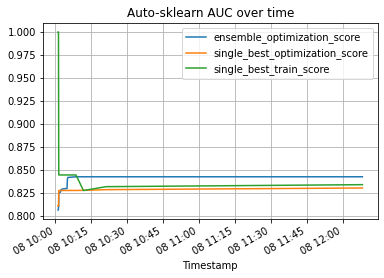

In [17]:
import matplotlib.pyplot as plt

poT = automl.performance_over_time_
poT.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn AUC over time',
    grid=True,
)
plt.show()


In [18]:
def get_metric_result(cv_results):
    results = pd.DataFrame.from_dict(cv_results)
    results = results[results['status'] == "Success"]
    cols = ['rank_test_scores', 'param_classifier:__choice__', 'mean_test_score']
    cols.extend([key for key in cv_results.keys() if key.startswith('metric_')])
    return results[cols]

print("Metric results")
print(get_metric_result(automl.cv_results_).to_string(index=False))



Metric results
 rank_test_scores param_classifier:__choice__  mean_test_score
              201               random_forest         0.811114
              221                 extra_trees         0.808408
              288           gradient_boosting         0.799896
               10                 extra_trees         0.828092
              137                         sgd         0.818250
              219               random_forest         0.809120
              500          passive_aggressive         0.708634
              475                         mlp         0.723176
              536               liblinear_svc         0.668029
              406          passive_aggressive         0.755776
              258           gradient_boosting         0.803727
              380           gradient_boosting         0.770945
              347           gradient_boosting         0.783189
              165                 extra_trees         0.814642
              629                       